In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Q1) Canny Edge Detection

In [2]:
def convert_to_gray_scale(image):
    r, g, b = image[..., 2], image[..., 1], image[..., 0]
    image_gray =  0.2989 * r + 0.5870 * g + 0.1140 * b
    return image_gray
    
def gaussian_blur(img, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Kx)
    Iy = cv2.filter2D(img, -1, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255
                
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

def threshold(img, lowThresholdRatio, highThresholdRatio):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

    
def manual_canny(image):
    print('Converting image to gray scale')
    image = convert_to_gray_scale(image)
    # Step 1: Noise reduction using Gaussian blur
    print('Blurring the image')
    blurred_image = gaussian_blur(image)
    print('Calculating Gradient')
    # Step 2: Gradient calculation using Sobel filters
    gradient_magnitude, gradient_direction = sobel_filters(blurred_image)
    print('Non-maximum suppression')
    # Step 3: Non-maximum suppression
    non_max_suppressed_image = non_max_suppression(gradient_magnitude, gradient_direction)
    print('Double threshold')
    # Step 4: Double threshold
    thresholded, weak, strong = threshold(non_max_suppressed_image, lowThresholdRatio=0.05, highThresholdRatio=0.09)
    # Step 5: Edge Tracking by Hysteresis
    edges = hysteresis(thresholded, weak, strong)
    return edges

In [3]:
roi_x, roi_y, roi_width, roi_height = -1, -1, -1, -1
drawing = False

# Mouse callback function
def get_roi(event, x, y, flags, param):
    global roi_x, roi_y, roi_width, roi_height, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_x, roi_y = x, y
        drawing = True
    elif event == cv2.EVENT_LBUTTONUP:
        roi_width, roi_height = x - roi_x, y - roi_y
        drawing = False
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        roi_width, roi_height = x - roi_x, y - roi_y

Converting image to gray scale
Blurring the image
Calculating Gradient
Non-maximum suppression
Double threshold


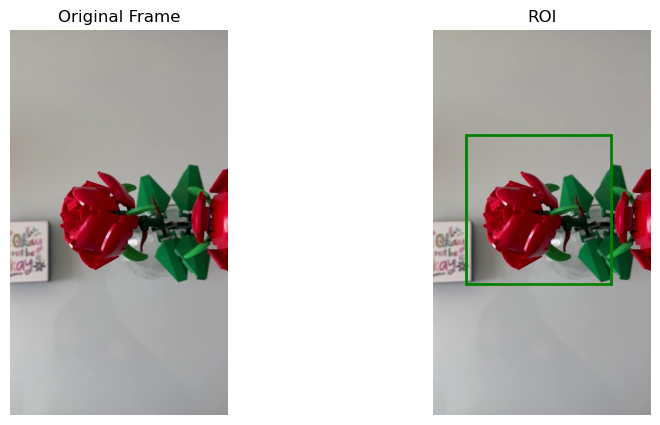

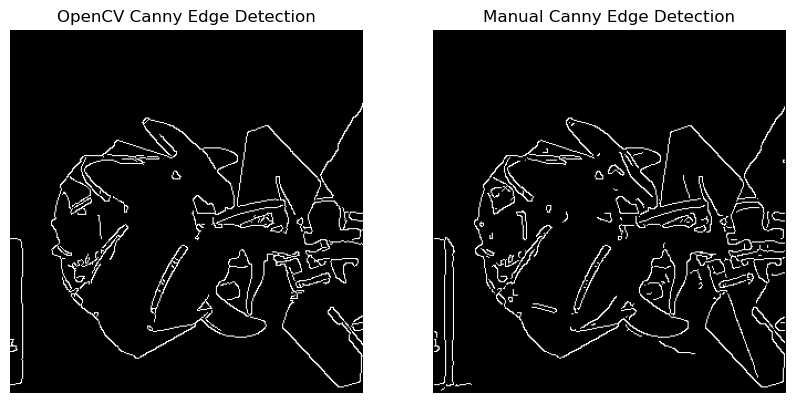

In [4]:
def main():
    video_path = 'video1.mp4'
    cap = cv2.VideoCapture(video_path)
    
    frame_idx = 140
    for i in range(frame_idx+1):
        ret, frame = cap.read()
    
    window_name = 'Select Region of Interest - Quit for q'
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, get_roi)
    
    while True:
        clone = frame.copy()
        if not drawing and roi_width > 0 and roi_height > 0:
            cv2.rectangle(clone, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 255, 0), 2)
        cv2.imshow(window_name, clone)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
    
    cv2.destroyAllWindows()
    
    roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
    
    # Manual Canny edge detection 
    canny_manual = manual_canny(roi)
    
    # Convert to grayscale
    gray_patch = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Using OpenCV's Canny edge detection function
    low_threshold = np.int32(50)
    high_threshold = np.int32(255)
    canny_opencv = cv2.Canny(gray_patch, low_threshold, high_threshold)
    
    cv2.imwrite('canny_manual_edge.png', canny_manual)
    cv2.imwrite('opencv_canny_edge.png', canny_opencv)
    
    # Display the selected frame with ROI
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Original Frame')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('ROI')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none'))
    
    plt.show()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(canny_opencv, cmap='gray')
    plt.title('OpenCV Canny Edge Detection')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(canny_manual, cmap='gray')
    plt.title('Manual Canny Edge Detection')
    plt.axis('off')
    
    plt.show()

if __name__ == "__main__":
    main()

# Q2) Harris Corner Detection

In [5]:
def find_harris_corners(input_img, k, window_size, threshold):
    corner_list = []
    output_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB)
    
    offset = int(window_size / 2)
    y_range, x_range = input_img.shape[0] - offset, input_img.shape[1] - offset
    
    # Calculate gradient components using numpy
    dy, dx = np.gradient(input_img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            # Define the window for local operations
            start_y, end_y = y - offset, y + offset + 1
            start_x, end_x = x - offset, x + offset + 1
            
            # Sum components within the window
            Sxx = Ixx[start_y:end_y, start_x:end_x].sum()
            Sxy = Ixy[start_y:end_y, start_x:end_x].sum()
            Syy = Iyy[start_y:end_y, start_x:end_x].sum()

            # Harris corner response calculation
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k * (trace**2)

            # Corner detection threshold
            if r > threshold:
                corner_list.append([x, y, r])
                output_img[y, x] = [0, 0, 255]  # Mark this pixel as red

    return corner_list, output_img

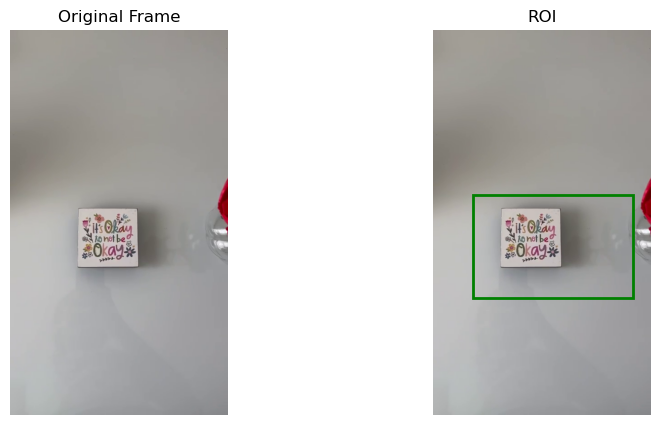

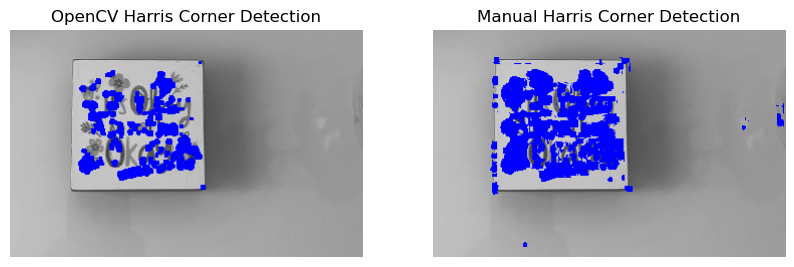

In [6]:
# Harris Corner Detection
def main():
    video_path = 'video1.mp4'
    cap = cv2.VideoCapture(video_path)
    
    frame_idx = 10
    for i in range(frame_idx+1):
        ret, frame = cap.read()
    
    window_name = 'Select Region of Interest - Quit for q'
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, get_roi)
    
    while True:
        clone = frame.copy()
        if not drawing and roi_width > 0 and roi_height > 0:
            cv2.rectangle(clone, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 255, 0), 2)
        cv2.imshow(window_name, clone)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
    
    cv2.destroyAllWindows()
    
    roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Setting parameters for Harris corner detection
    k = 0.04
    window_size = 5
    threshold = 10000.00
    
    # Manual harris Corners detection 
    manual_corner_list, manual_output_img = find_harris_corners(roi_gray, k, window_size, threshold)

    #Using OpenCV builtin library
    dst = cv2.cornerHarris(roi_gray, blockSize=window_size, ksize=window_size, k=k)
    threshold = 0.1
    # Thresholding
    dst_threshold = np.zeros_like(dst)
    dst_threshold[dst > threshold * dst.max()] = 255
    
    # Dilate the detected corners to make them more visible
    dst_threshold = cv2.dilate(dst_threshold, None)
    
    # Create an output image with corners drawn
    opencv_output_img = cv2.cvtColor(roi_gray.copy(), cv2.COLOR_GRAY2RGB)
    opencv_output_img[dst_threshold > 0] = [0, 0, 255]  # Draw corners in red
    
    cv2.imwrite('harris_manual_corner.png', manual_output_img)
    cv2.imwrite('opencv_harris_corner.png', opencv_output_img)
    
    # Display the selected frame with ROI
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Original Frame')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('ROI')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((roi_x, roi_y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none'))
    
    plt.show()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(opencv_output_img, cmap='gray')
    plt.title('OpenCV Harris Corner Detection')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(manual_output_img, cmap='gray')
    plt.title('Manual Harris Corner Detection')
    plt.axis('off')
    
    plt.show()

if __name__ == "__main__":
    main()

# Q3) SIFT Detector

In [7]:
video_path = 'video1.mp4'
cap = cv2.VideoCapture(video_path)

# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)

# Calculating the number of frames to skip (2 seconds)
frames_to_skip = int(fps * 2)

ret, frame1 = cap.read()

# Save the first frame
cv2.imwrite('frame1.jpg', frame1)

# Skip 2 seconds forward
cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_POS_FRAMES) + frames_to_skip)

# Capture the next frame
ret, frame2 = cap.read()

# Save the second frame
cv2.imwrite('frame2.jpg', frame2)

cap.release()


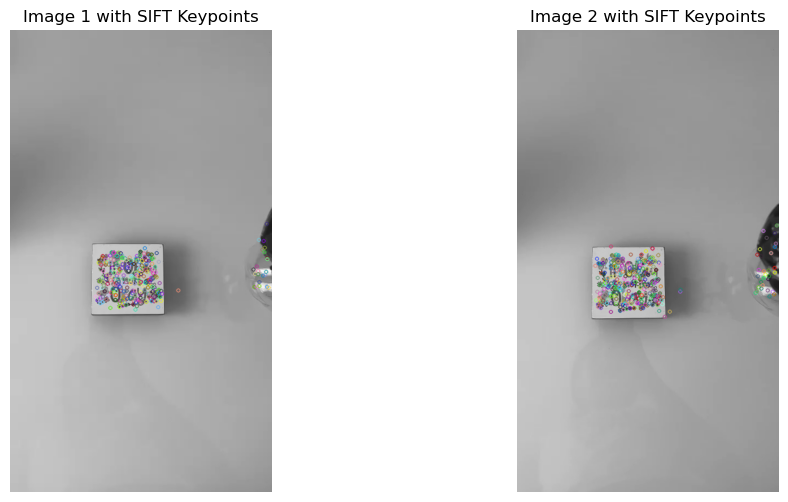

SSD between two SIFT vectors is  645.0


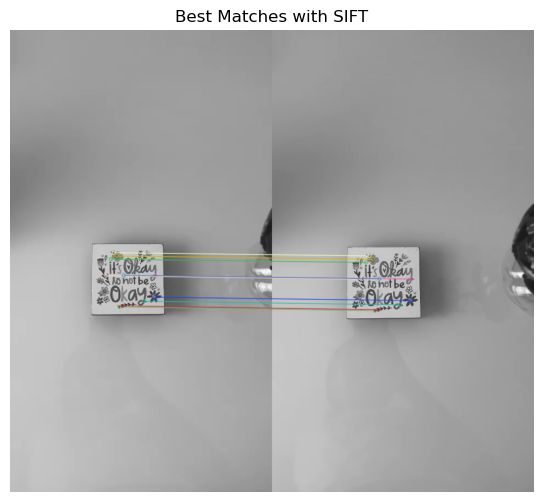

In [8]:
# Load the images
image1 = cv2.imread('frame1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('frame2.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

def compute_sift_descriptors(img):
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def calculate_ssd(descriptor1, descriptor2):
    ssd = np.sum((descriptor1 - descriptor2) ** 2)
    return ssd

keypoints1, descriptors1 = compute_sift_descriptors(image1)
keypoints2, descriptors2 = compute_sift_descriptors(image2)

bf = cv2.BFMatcher()
matches = bf.match(descriptors1, descriptors2)

# Initialize an empty image for drawing keypoints
image_with_keypoints1 = cv2.drawKeypoints(image1, keypoints1, None)
image_with_keypoints2 = cv2.drawKeypoints(image2, keypoints2, None)

# Display the images with keypoints using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_with_keypoints1, cmap='gray')
ax[0].set_title('Image 1 with SIFT Keypoints')
ax[0].axis('off')
ax[1].imshow(image_with_keypoints2, cmap='gray')
ax[1].set_title('Image 2 with SIFT Keypoints')
ax[1].axis('off')
plt.show()

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)
if matches:
    best_match = matches[0]
    descriptor1 = descriptors1[best_match.queryIdx]
    descriptor2 = descriptors2[best_match.trainIdx]
    ssd = calculate_ssd(descriptor1, descriptor2)
    print("SSD between two SIFT vectors is ", ssd)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(img_matches)
ax.set_title('Best Matches with SIFT')
ax.axis('off')
plt.show()

In [9]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

#Homography matrix using all matches (you may want to use RANSAC)
homography_matrix, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

# Inverse of the homography matrix
inverse_homography_matrix = np.linalg.inv(homography_matrix)

# Print the homography matrix and its inverse
print("Homography Matrix:")
print(homography_matrix)
print("\nInverse of Homography Matrix:")
print(inverse_homography_matrix)

Homography Matrix:
[[ 1.01654994e+00  6.35001856e-03 -1.61623564e+01]
 [-1.58037362e-02  1.03781680e+00 -3.51742452e+00]
 [-2.67761329e-05  3.15959834e-05  1.00000000e+00]]

Inverse of Homography Matrix:
[[ 9.84036697e-01 -6.50446404e-03  1.58814729e+01]
 [ 1.50724683e-02  9.63358398e-01  3.63214705e+00]
 [ 2.58724679e-05 -3.06124204e-05  1.00031048e+00]]


# Q4) Integral Image

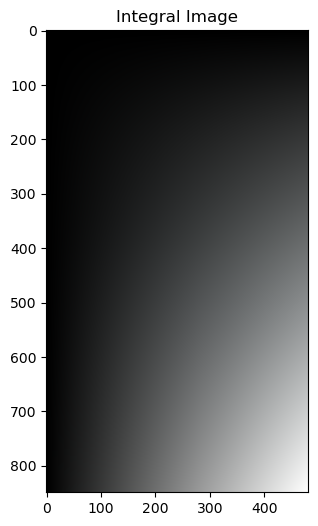

In [10]:
import cv2
import numpy as np

def manual_integral_image(img):
    # Convert image to float for precision
    img = img.astype(np.float64)
    
    # Initialize the integral image with zeros
    integral_img = np.zeros((img.shape[0] + 1, img.shape[1] + 1), dtype=np.float64)
    
    # Compute the integral image
    for y in range(1, integral_img.shape[0]):
        for x in range(1, integral_img.shape[1]):
            integral_img[y, x] = img[y - 1, x - 1] + integral_img[y, x - 1] + integral_img[y - 1, x] - integral_img[y - 1, x - 1]
    return integral_img

def compute_integral_images(rgb_image):
    # Split the channels
    channels = cv2.split(rgb_image)
    
    # Compute the integral image for each channel manually
    integral_images = [manual_integral_image(channel) for channel in channels]
    
    return integral_images

def display_integral_images(integral_images):
    imageTitles = ['Integral Image - Red','Integral Image - Green','Integral Image - Blue']
    plt.figure(figsize=(10,6))
    for i, each_integral_image in enumerate(integral_images, 1):
        ax = plt.subplot(1, 3, i)
        ax.imshow(each_integral_image, cmap='gray')
        ax.set_title(imageTitles[i-1])
    plt.show()
        
# Load the image
rgb_image = cv2.imread('frame1.jpg')

# Compute integral images manually
integral_images = compute_integral_images(rgb_image)
# display_integral_images(integral_images)

def normalize_integral_images(integral_images):
    normalized_images = []
    for img in integral_images:
        norm_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        normalized_images.append(norm_img.astype(np.uint8))
    return normalized_images

final_image = cv2.merge(normalize_integral_images(integral_images))
cv2.imwrite('integral_image_result.png', final_image)

plt.figure(figsize=(6, 6))
plt.imshow(final_image)
plt.title('Integral Image')
plt.show()


# Q5) Image Stitching

In [11]:
def pan_image_stitch(images):
    # Convert images to Gray
    image1 = cv2.cvtColor(images[0], cv2.IMREAD_GRAYSCALE)
    image2 = cv2.cvtColor(images[1], cv2.IMREAD_GRAYSCALE)

    # Initialize the SIFT detector
    sift = cv2.SIFT_create()
    
    def compute_sift_descriptors(img):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        return keypoints, descriptors

    def select_good_matches(matches):
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        good_matches = np.asarray(good_matches)
        return good_matches
    
    keypoints1, descriptors1 = compute_sift_descriptors(image1)
    keypoints2, descriptors2 = compute_sift_descriptors(image2)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    # Select Good Matches
    matches = select_good_matches(matches)

    # Initialize an empty image for drawing keypoints
    image_with_keypoints1 = cv2.drawKeypoints(image1, keypoints1, None)
    image_with_keypoints2 = cv2.drawKeypoints(image2, keypoints2, None)

    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    #Homography matrix
    homography_matrix, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    warped_image = cv2.warpPerspective(image1, homography_matrix, (image2.shape[1] + image1.shape[1], image2.shape[0]))
    
    # Combine both images
    stitched_image = warped_image.copy()
    stitched_image[0:image2.shape[0], 0:image2.shape[1]] = image2
    
    return stitched_image


In [12]:
def display_images(images):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img in enumerate(images):
        if img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = axs[i] if num_images > 1 else axs
        ax.imshow(img)
        ax.axis('off')

    plt.show()

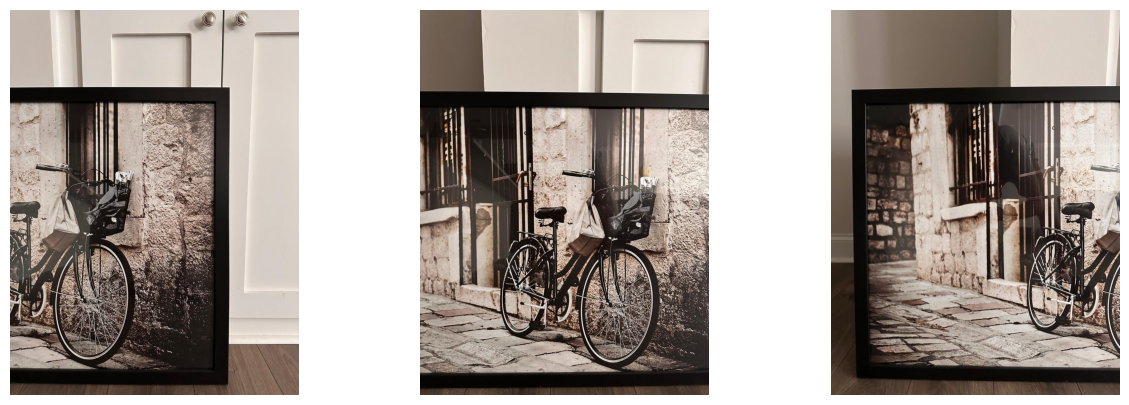

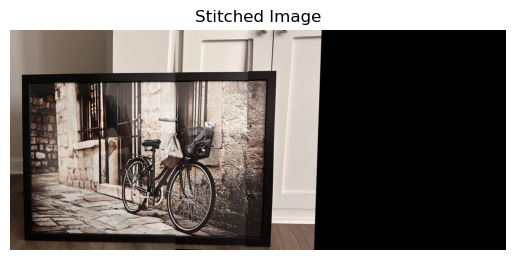

In [13]:
NUM_OF_IMAGES = 3
images=[]
for i in range(NUM_OF_IMAGES):
    images.append(cv2.imread("pan_images/p"+str(i+1)+".jpeg"))
display_images(images)

stitched_image = images[0]    
for i in range(1,len(images)):
    images_to_stitch=[stitched_image, images[i]]
    stitched_image = pan_image_stitch(images_to_stitch)
    
cv2.imwrite('stitched_image.jpg',stitched_image)
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.axis('off')
plt.show()